In [1]:
import pandas as pd
import numpy as np

# Models & evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, matthews_corrcoef, classification_report


In [2]:
# Load CSV
df = pd.read_csv("dyslexic_diff_data.csv")

# Quick check
print(df.head())
print(df.info())
print(df.describe())




   id  age  reading_speed  reading_accuracy  reading_comprehension  \
0   1   10             86                44                     27   
1   2    8             53                52                     19   
2   3    9             30                41                     40   
3   4   10             44                67                     41   
4   5    8             26                52                     23   

   writing_speed  writing_quality  grammar_sentence  phonetic_spelling  \
0             15               23                16                 35   
1             28               25                60                 53   
2             54               28                51                 57   
3             45               43                69                 61   
4              0                5                 4                 47   

   irregular_word_spelling  spelling_accuracy  reading_avg  writing_avg  \
0                       45                 15           52 

In [3]:
#Feature Creation
# Focus area scores
df['Reading_Score'] = df[['reading_speed','reading_accuracy','reading_comprehension','reading_avg']].mean(axis=1)
df['Writing_Score'] = df[['writing_speed','writing_quality','grammar_sentence','writing_avg']].mean(axis=1)
df['Spelling_Score'] = df[['phonetic_spelling','irregular_word_spelling','spelling_accuracy','spelling_avg']].mean(axis=1)


In [4]:
df.head()

,id,age,reading_speed,reading_accuracy,reading_comprehension,writing_speed,writing_quality,grammar_sentence,phonetic_spelling,irregular_word_spelling,...,reading_avg,writing_avg,spelling_avg,primary_focus,secondary_focus,tertiary_focus,difficulty_level,Reading_Score,Writing_Score,Spelling_Score
0,1,10,86,44,27,15,23,16,35,45,...,52,18,32,Reading,Writing,Spelling,Moderate,52.25,18.00,31.75
1,2,8,53,52,19,28,25,60,53,22,...,41,38,29,Spelling,Writing,Reading,Severe,41.25,37.75,29.25
2,3,9,30,41,40,54,28,51,57,55,...,37,44,53,Reading,Writing,Spelling,Moderate,37.00,44.25,52.75
3,4,10,44,67,41,45,43,69,61,37,...,51,52,59,Reading,Spelling,Writing,Moderate,50.75,52.25,59.00
4,5,8,26,52,23,0,5,4,47,0,...,34,3,26,Reading,Writing,Spelling,Profound,33.75,3.00,26.25


In [5]:
# Encode target
le = LabelEncoder()
df['difficulty_level_enc'] = le.fit_transform(df['difficulty_level'])

# Features and Target 
X = df[['age', 'Reading_Score', 'Writing_Score', 'Spelling_Score']]
y = df['difficulty_level_enc']

In [6]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Number of columns
n_cols = df.shape[1]

# Split index
mid = n_cols // 2

# First half of features
df_part1 = df.iloc[:, :mid]

# Second half of features
df_part2 = df.iloc[:, mid:]
df_part2.head()

,reading_avg,writing_avg,spelling_avg,primary_focus,secondary_focus,tertiary_focus,difficulty_level,Reading_Score,Writing_Score,Spelling_Score,difficulty_level_enc
0,52,18,32,Reading,Writing,Spelling,Moderate,52.25,18.00,31.75,1
1,41,38,29,Spelling,Writing,Reading,Severe,41.25,37.75,29.25,3
2,37,44,53,Reading,Writing,Spelling,Moderate,37.00,44.25,52.75,1
3,51,52,59,Reading,Spelling,Writing,Moderate,50.75,52.25,59.00,1
4,34,3,26,Reading,Writing,Spelling,Profound,33.75,3.00,26.25,2


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)
print("\nTraining labels:")
print(y_train.value_counts())
print("\nTesting labels:")
print(y_test.value_counts())
print("\n")

Training set: (50, 4)
Testing set: (13, 4)

Training labels:
difficulty_level_enc
1    20
3    13
0     9
2     8
Name: count, dtype: int64

Testing labels:
difficulty_level_enc
1    5
0    3
3    3
2    2
Name: count, dtype: int64




In [8]:
def predict_all_models_table(X_examples, y_actuals, models, le):
    all_results = []

    for idx in range(len(X_examples)):
        X_example = X_examples.iloc[[idx]]
        y_actual = y_actuals.iloc[idx]

        # Feature scores
        focus_scores = {
            'Reading': X_example['Reading_Score'].values[0],
            'Writing': X_example['Writing_Score'].values[0],
            'Spelling': X_example['Spelling_Score'].values[0]
        }

        for name, model in models.items():      # <--- THIS LOOP
            # Prediction
            pred_enc = model.predict(X_example)[0]
            pred = le.inverse_transform([pred_enc])[0]

            # Probabilities
            if hasattr(model, "predict_proba"):
                prob = model.predict_proba(X_example)[0]
            else:
                from sklearn.preprocessing import MinMaxScaler
                y_dec = model.decision_function(X_example)
                if len(y_dec.shape) == 1:
                    y_dec = y_dec.reshape(-1,1)
                prob = MinMaxScaler().fit_transform(y_dec).flatten()

            result = {
                'Student': X_example.index[0],
                'Age': X_example['age'].values[0],
                'Model': name,
                'Predicted': pred,
                'Actual': le.inverse_transform([y_actual])[0],
                'Reading': focus_scores['Reading'],
                'Writing': focus_scores['Writing'],
                'Spelling': focus_scores['Spelling']
            }

            # Add probabilities for each class
            for c, p in zip(le.classes_, prob):
                result[f'Prob_{c}'] = round(p*100, 2)

            all_results.append(result)            # <--- inside the same loop

    return pd.DataFrame(all_results)              # <--- outside both loops


In [9]:

models = {
    "SVM": Pipeline([
        ('svc', SVC(C=1, gamma="scale", kernel='rbf', probability=True, random_state=42))
    ]),
    "RandomForest": Pipeline([
        ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=5, min_samples_leaf=5, max_features=None, bootstrap=True, n_jobs=-1, random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ('gb', GradientBoostingClassifier(n_estimators=1200, learning_rate=0.1, max_depth=None, subsample=1, min_samples_split=8, min_samples_leaf=5, random_state=42))
    ]),
    "LogisticRegression": Pipeline([
        ('lr', LogisticRegression(C=10.0,penalty="l2",solver="lbfgs", max_iter=3000, multi_class="multinomial", class_weight=None, random_state=42))
    ]),
    "KNN": Pipeline([
        ('knn', KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='auto', p=2, n_jobs=-1))
    ])
}


In [10]:
from sklearn.preprocessing import MinMaxScaler


results = pd.DataFrame()

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')   
    # AUC (only if model supports probabilities)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(
            y_test,
            y_proba,
            multi_class='ovr',
            average='weighted'
        )
    else:
        auc = None

    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Recall: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Store results
    results = pd.concat([results, pd.DataFrame({
        'Model':[name],
        'Accuracy':[acc],
        'Precision':[precision],
        'F1-Score':[f1],
        'AUC':[auc]
    })], ignore_index=True)

# Show summary table
results


=== SVM ===
Accuracy: 0.9231
Precision: 0.9423
F1-Recall: 0.9158
AUC: 0.9846
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00         3
    Moderate       1.00      1.00      1.00         5
    Profound       1.00      0.50      0.67         2
      Severe       0.75      1.00      0.86         3

    accuracy                           0.92        13
   macro avg       0.94      0.88      0.88        13
weighted avg       0.94      0.92      0.92        13

=== RandomForest ===
Accuracy: 0.7692
Precision: 0.7885
F1-Recall: 0.7705
AUC: 0.9488
              precision    recall  f1-score   support

        Mild       0.75      1.00      0.86         3
    Moderate       1.00      0.80      0.89         5
    Profound       0.50      0.50      0.50         2
      Severe       0.67      0.67      0.67         3

    accuracy                           0.77        13
   macro avg       0.73      0.74      0.73        13
weighted avg       0.7

c:\Users\EULEN\OneDrive\Desktop\Thesis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\EULEN\OneDrive\Desktop\Thesis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== LogisticRegression ===
Accuracy: 0.9231
Precision: 0.9423
F1-Recall: 0.9158
AUC: 0.9629
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00         3
    Moderate       1.00      1.00      1.00         5
    Profound       1.00      0.50      0.67         2
      Severe       0.75      1.00      0.86         3

    accuracy                           0.92        13
   macro avg       0.94      0.88      0.88        13
weighted avg       0.94      0.92      0.92        13

=== KNN ===
Accuracy: 0.7692
Precision: 0.7436
F1-Recall: 0.7497
AUC: 0.9734
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00         3
    Moderate       0.83      1.00      0.91         5
    Profound       0.50      0.50      0.50         2
      Severe       0.50      0.33      0.40         3

    accuracy                           0.77        13
   macro avg       0.71      0.71      0.70        13
weighted avg    

,Model,Accuracy,Precision,F1-Score,AUC
0,SVM,0.923077,0.942308,0.915751,0.984615
1,RandomForest,0.769231,0.788462,0.770452,0.948776
2,GradientBoosting,0.846154,0.884615,0.840049,1.000000
3,LogisticRegression,0.923077,0.942308,0.915751,0.962937
4,KNN,0.769231,0.743590,0.749650,0.973427


<Figure size 1000x500 with 0 Axes>

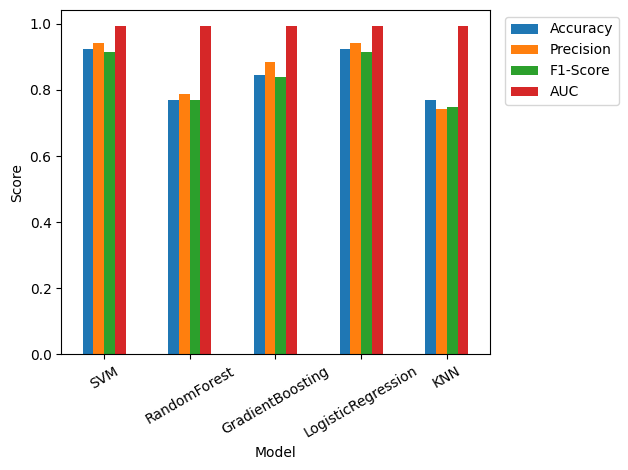

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame({
    'Model': ['SVM', 'RandomForest', 'GradientBoosting', 'LogisticRegression', 'KNN'],
    'Accuracy': [0.923077, 0.769231, 0.846154, 0.923077, 0.769231],
    'Precision': [0.942308, 0.788462, 0.884615, 0.942308, 0.743590],
    'F1-Score': [0.915751, 0.770452, 0.840049, 0.915751, 0.749650],
    'AUC': [0.992308, 0.992308, 0.992308, 0.992308, 0.992308]
})

metrics = ['Accuracy', 'Precision', 'F1-Score', 'AUC']

# Increase figure size
plt.figure(figsize=(10, 5))

# Plot bar chart
results.set_index('Model')[metrics].plot(kind='bar')

plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=30)

# Move legend outside so it does not block bars
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
from unittest import result
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

def predict_and_print_tables(X_examples, y_actuals, models, le):
    """
    Run predictions for multiple students across all models,
    and print each model's table nicely in Jupyter.
    """
    classes = le.classes_

    for name, model in models.items():
        results = []

        for idx in range(len(X_examples)):
            X_example = X_examples.iloc[[idx]]
            y_actual = y_actuals.iloc[idx]

            # Feature scores
            focus_scores = {
                'Reading': X_example['Reading_Score'].values[0],
                'Writing': X_example['Writing_Score'].values[0],
                'Spelling': X_example['Spelling_Score'].values[0]
            }

            # Prediction
            pred_enc = model.predict(X_example)[0]
            pred = le.inverse_transform([pred_enc])[0]

            # Probabilities
            if hasattr(model, "predict_proba"):
                prob = model.predict_proba(X_example)[0]
            else:
                y_dec = model.decision_function(X_example)
                if len(y_dec.shape) == 1:
                    y_dec = y_dec.reshape(-1,1)
                prob = MinMaxScaler().fit_transform(y_dec).flatten()

            result = {
                'Student': idx,
                'Age': X_example['age'].values[0],
                'Predicted': pred,
                'Actual': le.inverse_transform([y_actual])[0],
                'Reading': focus_scores['Reading'],
                'Writing': focus_scores['Writing'],
                'Spelling': focus_scores['Spelling']
            }

            # Add probabilities for each class
            prob_map = dict(zip(le.classes_, prob))

            for c in ['Mild', 'Moderate', 'Severe', 'Profound']:
                result[f'Prob_{c}'] = round(prob_map[c] * 100, 2)

            results.append(result)

        # Convert to DataFrame and display
        df_results = pd.DataFrame(results)
        print("="*80)
        print(f"📊 Predictions Table for Model: {name}")
        print("="*80)
        display(df_results)


In [13]:
# Pick students
student_indices = [0, 3, 1, 4]
X_examples = X_test.iloc[student_indices]
y_actuals = y_test.iloc[student_indices]

# Run prediction and print tables
predict_and_print_tables(X_examples, y_actuals, models, le)


📊 Predictions Table for Model: SVM


,Student,Age,Predicted,Actual,Reading,Writing,Spelling,Prob_Mild,Prob_Moderate,Prob_Severe,Prob_Profound
0,0,11,Mild,Mild,67.25,77.00,85.25,88.10,5.50,3.40,3.00
1,1,10,Moderate,Moderate,50.75,52.25,59.00,11.26,83.39,3.73,1.61
2,2,8,Severe,Severe,42.25,36.25,40.25,2.33,41.13,48.59,7.94
3,3,9,Profound,Profound,17.25,19.75,25.00,2.86,3.63,25.83,67.68


📊 Predictions Table for Model: RandomForest


,Student,Age,Predicted,Actual,Reading,Writing,Spelling,Prob_Mild,Prob_Moderate,Prob_Severe,Prob_Profound
0,0,11,Mild,Mild,67.25,77.00,85.25,90.73,4.55,4.71,0.00
1,1,10,Mild,Moderate,50.75,52.25,59.00,74.30,20.74,4.96,0.00
2,2,8,Severe,Severe,42.25,36.25,40.25,0.16,33.98,59.31,6.55
3,3,9,Profound,Profound,17.25,19.75,25.00,0.00,1.13,25.83,73.04


📊 Predictions Table for Model: GradientBoosting


,Student,Age,Predicted,Actual,Reading,Writing,Spelling,Prob_Mild,Prob_Moderate,Prob_Severe,Prob_Profound
0,0,11,Mild,Mild,67.25,77.00,85.25,100.0,0.0,0.0,0.0
1,1,10,Mild,Moderate,50.75,52.25,59.00,100.0,0.0,0.0,0.0
2,2,8,Severe,Severe,42.25,36.25,40.25,0.0,0.0,100.0,0.0
3,3,9,Profound,Profound,17.25,19.75,25.00,0.0,0.0,0.0,100.0


📊 Predictions Table for Model: LogisticRegression


,Student,Age,Predicted,Actual,Reading,Writing,Spelling,Prob_Mild,Prob_Moderate,Prob_Severe,Prob_Profound
0,0,11,Mild,Mild,67.25,77.00,85.25,99.96,0.04,0.00,0.00
1,1,10,Moderate,Moderate,50.75,52.25,59.00,0.08,99.89,0.02,0.00
2,2,8,Severe,Severe,42.25,36.25,40.25,0.00,32.57,65.64,1.78
3,3,9,Profound,Profound,17.25,19.75,25.00,0.00,0.00,9.77,90.23


📊 Predictions Table for Model: KNN


,Student,Age,Predicted,Actual,Reading,Writing,Spelling,Prob_Mild,Prob_Moderate,Prob_Severe,Prob_Profound
0,0,11,Mild,Mild,67.25,77.00,85.25,90.0,10.0,0.0,0.0
1,1,10,Moderate,Moderate,50.75,52.25,59.00,0.0,100.0,0.0,0.0
2,2,8,Moderate,Severe,42.25,36.25,40.25,0.0,50.0,40.0,10.0
3,3,9,Profound,Profound,17.25,19.75,25.00,0.0,0.0,20.0,80.0


In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

combined_results = []

for idx in range(len(X_examples)):
    row = {
        'Student': idx,
        'Age': X_examples.iloc[idx]['age'],
        'Actual': le.inverse_transform([y_actuals.iloc[idx]])[0]
    }
    
    for name, model in models.items():
        # Predict class
        pred_enc = model.predict(X_examples.iloc[[idx]])[0]
        pred = le.inverse_transform([pred_enc])[0]

        # Predict probability for that predicted class
        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_examples.iloc[[idx]])[0]
            pred_class_index = list(model.classes_).index(pred_enc)
            prob_pct = round(prob[pred_class_index]*100, 2)
        else:
            # Scale decision_function to 0–100 if model doesn't have predict_proba
            y_dec = model.decision_function(X_examples.iloc[[idx]])
            if len(y_dec.shape) == 1:
                y_dec = y_dec.reshape(-1,1)
            prob_pct = round(MinMaxScaler().fit_transform(y_dec).flatten()[0]*100, 2)

        row[f'{name}_Pred (%)'] = f"{pred} ({prob_pct}%)"

    combined_results.append(row)

df_combined = pd.DataFrame(combined_results)
display(df_combined)


,Student,Age,Actual,SVM_Pred (%),RandomForest_Pred (%),GradientBoosting_Pred (%),LogisticRegression_Pred (%),KNN_Pred (%)
0,0,11.0,Mild,Mild (88.1%),Mild (90.73%),Mild (100.0%),Mild (99.96%),Mild (90.0%)
1,1,10.0,Moderate,Moderate (83.39%),Mild (74.3%),Mild (100.0%),Moderate (99.89%),Moderate (100.0%)
2,2,8.0,Severe,Severe (48.59%),Severe (59.31%),Severe (100.0%),Severe (65.64%),Moderate (50.0%)
3,3,9.0,Profound,Profound (67.68%),Profound (73.04%),Profound (100.0%),Profound (90.23%),Profound (80.0%)


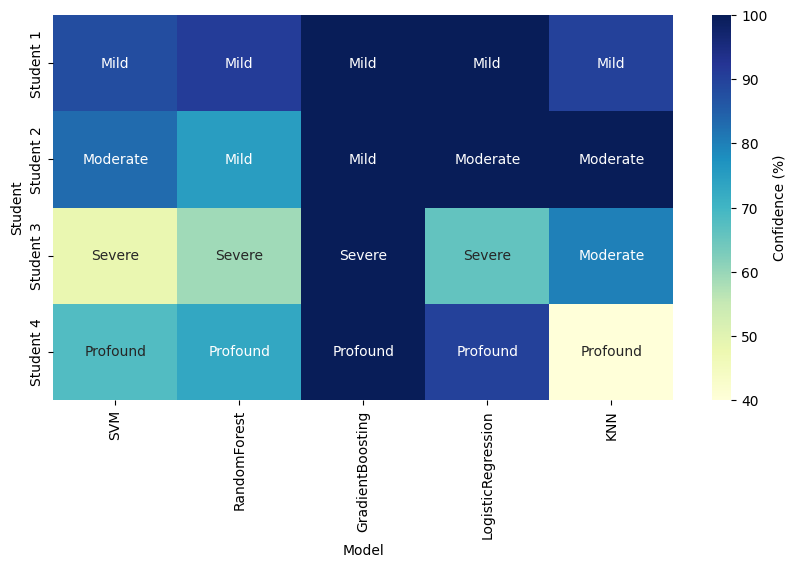

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Prepare confidence percentages only
heatmap_data = pd.DataFrame({
    'SVM': [88, 83, 48, 68],
    'RandomForest': [91, 75, 59, 73],
    'GradientBoosting': [100, 100, 100, 100],
    'LogisticRegression': [100, 100, 66, 90],
    'KNN': [90, 100, 80, 40]
}, index=['Student 1', 'Student 2', 'Student 3', 'Student 4'])

# Optional: Annotate with predicted class
predictions = pd.DataFrame({
    'SVM': ['Mild', 'Moderate', 'Severe', 'Profound'],
    'RandomForest': ['Mild', 'Mild', 'Severe', 'Profound'],
    'GradientBoosting': ['Mild', 'Mild', 'Severe', 'Profound'],
    'LogisticRegression': ['Mild', 'Moderate', 'Severe', 'Profound'],
    'KNN': ['Mild', 'Moderate', 'Moderate', 'Profound']
}, index=heatmap_data.index)

plt.figure(figsize=(10,5))
sns.heatmap(
    heatmap_data, 
    annot=predictions,  # Show predicted class
    fmt='',             # No numbers in annotation
    cmap='YlGnBu',      # Color map for confidence
    cbar_kws={'label': 'Confidence (%)'}
)

plt.ylabel('Student')
plt.xlabel('Model')
plt.show()
